In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [156]:
from PIL import Image

In [157]:
image1 = Image.open("/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/gg (10).jpg")
image2 = Image.open("/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/gg (105).jpg")
image3 = Image.open("/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor/m (113).jpg")

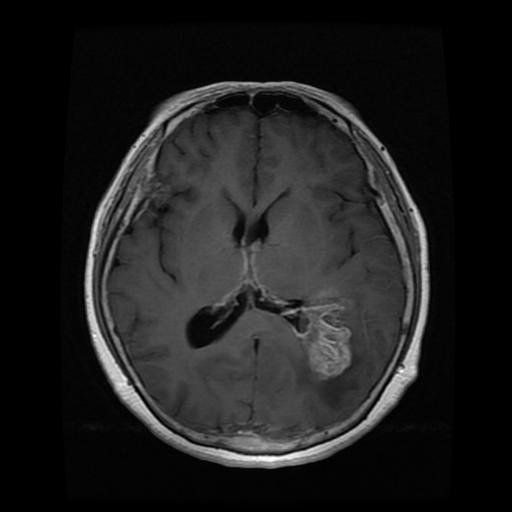

In [158]:
image1

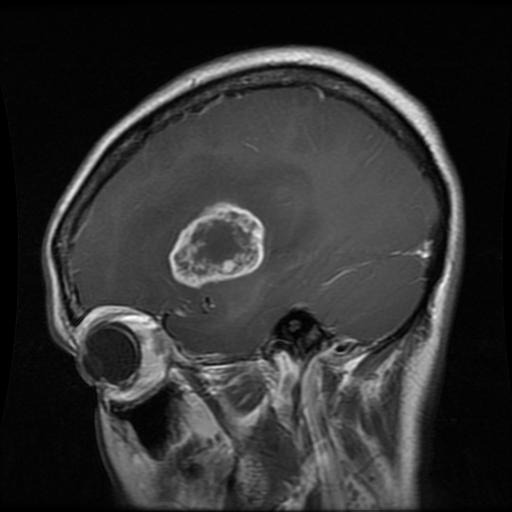

In [159]:
image2

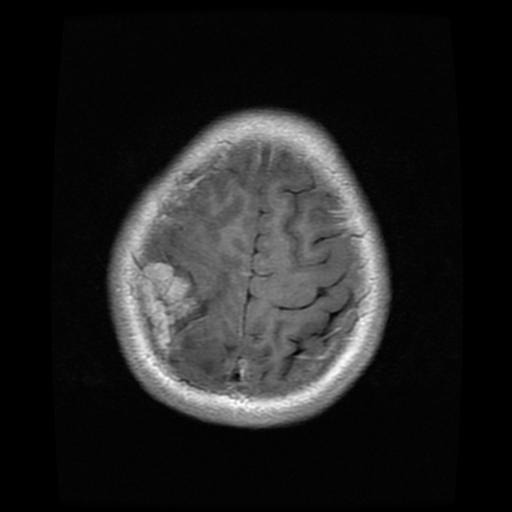

In [160]:
image3

In [161]:
image1.size, image2.size, image3.size     # Each has same size

((512, 512), (512, 512), (512, 512))

In [162]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [163]:
data = ImageDataGenerator(rescale = 1/255.0, 
                          featurewise_center=False, 
                          samplewise_center=False, featurewise_std_normalization=False, 
                          samplewise_std_normalization=False, zca_whitening=False, 
                          zca_epsilon=1e-6, rotation_range=0, width_shift_range=0., 
                          height_shift_range=0., brightness_range=None, shear_range=0., 
                          zoom_range=0., channel_shift_range=0., fill_mode='nearest', 
                          cval=0., horizontal_flip=False, vertical_flip=False, 
                          preprocessing_function=None, data_format=None, 
                          validation_split=0.0)

In [164]:
trainData = data.flow_from_directory(directory = "/kaggle/input/brain-tumor-classification-mri/Training", 
                                     target_size=(128, 128),class_mode='categorical', batch_size=32,shuffle=True)

Found 2870 images belonging to 4 classes.


In [165]:
testData = data.flow_from_directory(directory = "/kaggle/input/brain-tumor-classification-mri/Testing", 
                                    target_size=(128, 128),class_mode='categorical', batch_size=32,shuffle=True)

Found 394 images belonging to 4 classes.


In [166]:
import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, MaxPooling2D, Dropout

In [188]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation ="relu", input_shape=(128,128,3)))
model.add(Conv2D(32, kernel_size = (3,3), activation ="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size = (3,3), activation ="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation ="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(32, activation ="relu"))
model.add(Dense(64, activation ="relu"))
model.add(Dense(32, activation ="relu"))
model.add(Dense(4, activation ="softmax"))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 28, 28, 128)     

In [189]:
!pip install visualkeras
import visualkeras

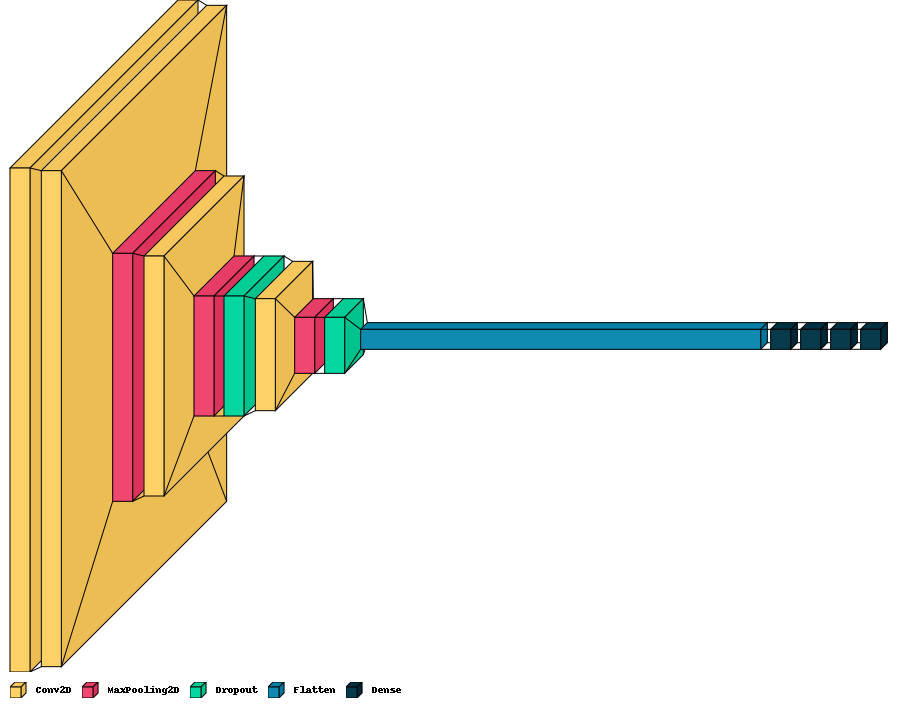

In [190]:
visualkeras.layered_view(model, legend = True)

In [203]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [204]:
import tensorflow as tf

In [205]:
tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

In [206]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [209]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 5, verbose = 1)

In [210]:
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, verbose = 1)

In [211]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])        # Adam Optimizer help us to find the largest and the smallest value by using gradient descend 

In [212]:
history = model.fit(trainData, steps_per_epoch= len(trainData), epochs = 30, verbose= 1, validation_data = testData, validation_steps = len(testData), callbacks=[reduce_lr, earlyStop,checkpoint])

Epoch 1/30
90/90 [==============================] - 14s 150ms/step - loss: 0.0224 - accuracy: 0.9857 - val_loss: 1.3030 - val_accuracy: 0.7513

Epoch 00001: val_accuracy improved from -inf to 0.75127, saving model to /tmp/checkpoint
Epoch 2/30
90/90 [==============================] - 13s 147ms/step - loss: 0.0143 - accuracy: 0.9909 - val_loss: 1.2957 - val_accuracy: 0.7513

Epoch 00002: val_accuracy did not improve from 0.75127
Epoch 3/30
90/90 [==============================] - 13s 146ms/step - loss: 0.0057 - accuracy: 0.9965 - val_loss: 1.6607 - val_accuracy: 0.7487

Epoch 00003: val_accuracy did not improve from 0.75127
Epoch 4/30
90/90 [==============================] - 14s 152ms/step - loss: 0.0049 - accuracy: 0.9969 - val_loss: 1.6518 - val_accuracy: 0.7462

Epoch 00004: val_accuracy did not improve from 0.75127
Epoch 5/30
90/90 [==============================] - 13s 141ms/step - loss: 0.0063 - accuracy: 0.9962 - val_loss: 1.8815 - val_accuracy: 0.7462

Epoch 00005: val_accuracy 

### Model saving

In [ ]:
model.save("tumor_model.h5")